# SINVAD Experiments - Research Question 2 (Indecisiveness)

This notebook provides outlines on experiments performed for RQ2 (Section 5.3 of paper). It contains code that generates results for Table 1 in the paper. Here we only present the code for MNIST; the principle is similar for CIFAR-10. The paper contains a typo; in Table 1 the paper reports MNIST results, but they are actually FashionMNIST results, which is the reason of the deviation from the results in the paper. 

## Step 0. Preparation

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm_n
plt.style.use('seaborn')

from sa.model import MnistClassifier
from vae.model import VAE

In [2]:
img_size = 28*28*1
torch.no_grad() # since nothing is trained here

In [3]:
vae = VAE(img_size = 28*28, h_dim = 1600, z_dim = 400)
vae.load_state_dict(torch.load('./vae/models/MNIST_EnD.pth'))
vae.cuda()

classifier = MnistClassifier(img_size = img_size)
classifier.load_state_dict(torch.load('./sa/models/MNIST_conv_classifier.pth'))
classifier.cuda()
print("models loaded")

models loaded


In [4]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=False)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
print("Data loader ready")

Data loader ready


## Step 1. Calculate prediction variance in different datasets

In [5]:
def pred_diff(img, classifier, rep_num = 10):
    preds = []
    prob_f = nn.Softmax(dim=1)
    for r_idx in range(rep_num):
        pred = prob_f(classifier(img))
        preds.append(pred)
    preds = torch.cat(preds, dim=0)
    stds = torch.std(preds, dim=0)
    return stds

In [6]:
norm_accum = 0.
for i, (x, x_class) in tqdm_n(enumerate(test_data_loader)):
    samp_img = x[0:1].cuda()
    diff = pred_diff(samp_img, classifier)
    norm_accum += diff.sum().item()
print('Dataset test image variation:', norm_accum/10000)

/home/sungmin/Documents/dlTestGen/opensource-icse2020/osenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Dataset test image variation: 0.021665634684952455


In [7]:
bound_imgs = np.load('./data/bound_imgs_MNIST.npy')

In [8]:
batch_imgs = bound_imgs.reshape((1, 10000, 28, 28))
batch_imgs = batch_imgs.transpose((1, 0, 2, 3))
tensor_imgs = torch.Tensor(batch_imgs).cuda()

In [9]:
bound_accum = 0.
for img_idx in tqdm_n(range(10000)):
    tensor_img = tensor_imgs[img_idx:img_idx+1]
    diff = pred_diff(tensor_img, classifier)
    bound_accum += diff.sum().item()
print('SINVAD-generated image variation:', bound_accum/10000)

/home/sungmin/Documents/dlTestGen/opensource-icse2020/osenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



SINVAD-generated image variation: 0.6997887066062334


## Appenndix. Visualization of SINVAD-generated images

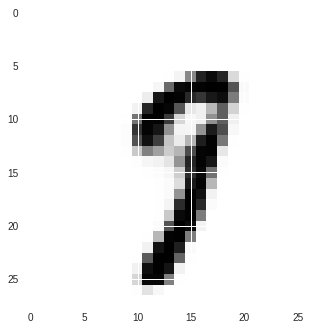

In [10]:
plt.imshow(tensor_img[0][0].cpu())